In [239]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

In [268]:
df = pd.read_json('../Data/combined.json')

In [269]:
df.head()

,DocumentDate,SalePrice,PropertyType,PrincipalUse,SaleReason,PropertyClass,SaleWarning,Area,SqFtLot,LakeWashington,...,TidelandShoreland,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition,year
95779180,1546300800000,644950,2,6,1,8,4,27.0,6501.0,0.0,...,0.0,0.0,0.0,N,N,3265.0,0.0,30.0,3.0,2019
857600280,1546300800000,449950,2,6,1,8,,57.0,3599.0,0.0,...,0.0,0.0,0.0,N,N,2360.0,0.0,180.0,3.0,2019
769100220,1546300800000,544950,3,6,1,8,,41.0,10051.0,0.0,...,0.0,0.0,0.0,N,N,3050.0,0.0,320.0,3.0,2019
531510630,1546300800000,477000,3,6,18,8,18 51 52,34.0,9082.0,0.0,...,0.0,0.0,0.0,N,N,1620.0,0.0,0.0,4.0,2019
857600260,1546300800000,583950,2,6,1,8,,57.0,5944.0,0.0,...,0.0,0.0,0.0,N,N,3270.0,0.0,250.0,3.0,2019


In [270]:
df.SalePrice.mean()

1826994.8453734834

In [271]:
# We had enough data that I dropped all the NAN's. Could go back if we decide we want to look at them. about 8K out of the 36K 
df.dropna(inplace=True)

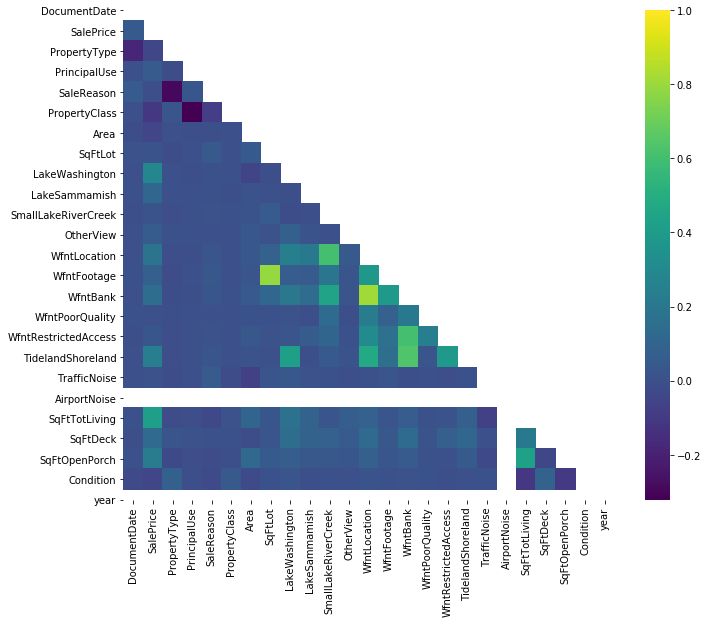

In [272]:
# Heat map comparing the respective columns. Looks like we can take out Airport noise as it has no efffect. 
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

In [273]:
# created a first model dataframe to only inclue SalePrice and sqfttotliving
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()

In [274]:
#First model using SalePrice as target variable and sqFtTotLiving as feature
# real low R-Squared. Doesnt necisarrily mean a bad thing if this is our very first model 
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data=fsm_df)
fsm_results = fsm.fit()

In [275]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     5396.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:22   Log-Likelihood:            -3.8504e+05
No. Observations:               25679   AIC:                         7.701e+05
Df Residuals:                   25677   BIC:                         7.701e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.943e+04    1.2e+04      1.622      0.105   -4054.122    4.29e+04
SqFtTotLiving   368.3709      5.015     73.457      0.000     358.542     378.200
==============================================================================
Omnibus:                    50432.432   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        185484705.274
Skew:                          15.614   Prob(JB):                         0.00
Kurtosis:                     418.189   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [276]:
#waterfront dataframe includes SalePrice and LakeWashington

fsm_water_df = df[['SalePrice', 'LakeWashington']].copy()

In [277]:
#Using ordinary least squares, SalePrice as target variable, LakeWashington as ind var
#Rsquared value of 0.085 is quite low

fsm_water = ols(formula="SalePrice~LakeWashington", data=fsm_water_df)
fsm_water_results=fsm_water.fit()

In [278]:
fsm_water_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2385.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:26   Log-Likelihood:            -3.8635e+05
No. Observations:               25679   AIC:                         7.727e+05
Df Residuals:                   25677   BIC:                         7.727e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       7.846e+05   5222.793    150.224      0.000    7.74e+05    7.95e+05
LakeWashington  6.236e+05   1.28e+04     48.838      0.000    5.99e+05    6.49e+05
==============================================================================
Omnibus:                    46267.837   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        111070186.983
Skew:                          12.955   Prob(JB):                         0.00
Kurtosis:                     324.149   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [279]:
df.head()

,DocumentDate,SalePrice,PropertyType,PrincipalUse,SaleReason,PropertyClass,SaleWarning,Area,SqFtLot,LakeWashington,...,TidelandShoreland,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition,year
95779180,1546300800000,644950,2,6,1,8,4,27.0,6501.0,0.0,...,0.0,0.0,0.0,N,N,3265.0,0.0,30.0,3.0,2019
857600280,1546300800000,449950,2,6,1,8,,57.0,3599.0,0.0,...,0.0,0.0,0.0,N,N,2360.0,0.0,180.0,3.0,2019
769100220,1546300800000,544950,3,6,1,8,,41.0,10051.0,0.0,...,0.0,0.0,0.0,N,N,3050.0,0.0,320.0,3.0,2019
531510630,1546300800000,477000,3,6,18,8,18 51 52,34.0,9082.0,0.0,...,0.0,0.0,0.0,N,N,1620.0,0.0,0.0,4.0,2019
857600260,1546300800000,583950,2,6,1,8,,57.0,5944.0,0.0,...,0.0,0.0,0.0,N,N,3270.0,0.0,250.0,3.0,2019


In [280]:
df.shape

(25679, 30)

In [281]:
column1 = df.iloc[:, 0:5].copy()
column2 = df.iloc[:, 5:10].copy()
column3 = df.iloc[:, 10:15].copy()
column4 = df.iloc[:, 15:20].copy()
column5 = df.iloc[:, 20:25].copy()
column6 = df.iloc[:, 25:30].copy()

In [282]:
column2_drop = column2.drop(columns='SaleWarning')

In [283]:
column2_drop

,PropertyClass,Area,SqFtLot,LakeWashington
95779180,8,27.0,6501.0,0.0
857600280,8,57.0,3599.0,0.0
769100220,8,41.0,10051.0,0.0
531510630,8,34.0,9082.0,0.0
857600260,8,57.0,5944.0,0.0
...,...,...,...,...
951405600,8,35.0,4197.0,0.0
815577110,8,61.0,6447.0,0.0
809001865,8,12.0,4000.0,0.0
7942601685,8,15.0,5120.0,0.0


In [284]:
df.PowerLines.replace(('Y', 'N'), (1, 0), inplace=True)

In [285]:
df.OtherNuisances.replace(('Y', 'N'), (1, 0), inplace=True)

In [286]:
column4

,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence
95779180,0.0,0.0,0.0,N,N
857600280,0.0,0.0,0.0,N,N
769100220,0.0,0.0,0.0,N,N
531510630,0.0,0.0,0.0,N,N
857600260,0.0,0.0,0.0,N,N
...,...,...,...,...,...
951405600,0.0,0.0,0.0,N,N
815577110,0.0,0.0,0.0,N,N
809001865,0.0,0.0,0.0,N,N
7942601685,0.0,0.0,0.0,N,N


In [287]:
df.columns

Index(['DocumentDate', 'SalePrice', 'PropertyType', 'PrincipalUse',
       'SaleReason', 'PropertyClass', 'SaleWarning', 'Area', 'SqFtLot',
       'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView',
       'WfntLocation', 'WfntFootage', 'WfntBank', 'WfntPoorQuality',
       'WfntRestrictedAccess', 'WfntAccessRights', 'WfntProximityInfluence',
       'TidelandShoreland', 'TrafficNoise', 'AirportNoise', 'PowerLines',
       'OtherNuisances', 'SqFtTotLiving', 'SqFtDeck', 'SqFtOpenPorch',
       'Condition', 'year'],
      dtype='object')

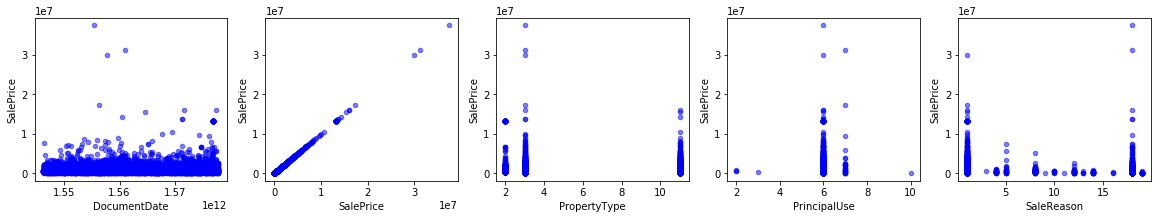

In [288]:
#Identifying categorical variables
#Dropping PrincipalUse & SaleReason columns
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

for xcol, ax in zip((column1), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

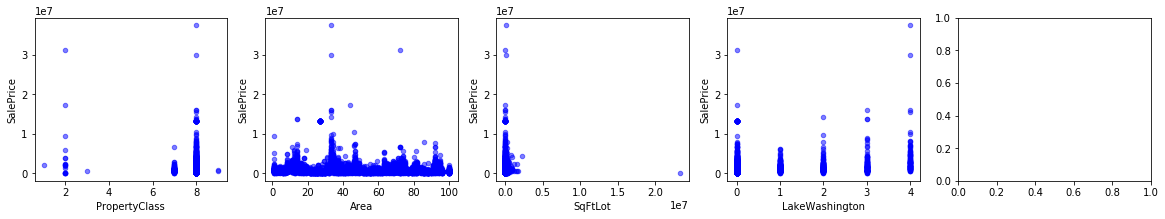

In [289]:
#Dropping SaleWarning & PropertyClass columns
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

for xcol, ax in zip((column2_drop), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

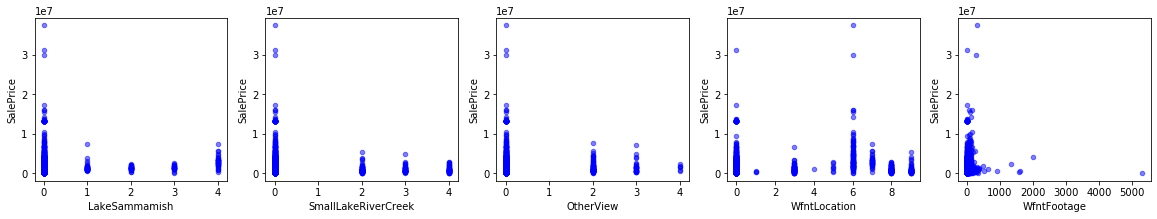

In [290]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

for xcol, ax in zip((column3), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

ValueError: scatter requires x column to be numeric

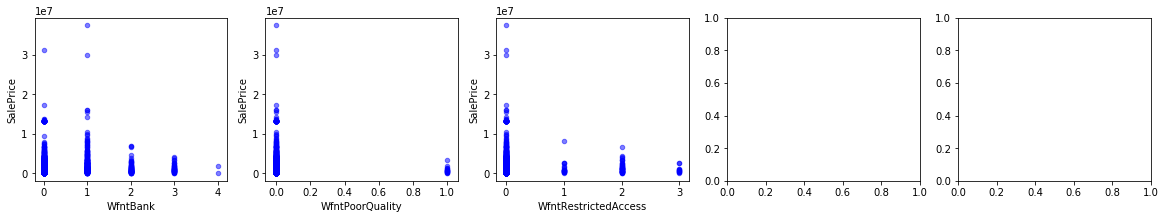

In [291]:
#WfntAccessRights & WfntProximityInfluence columns contained only NaN values
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

for xcol, ax in zip((column4), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

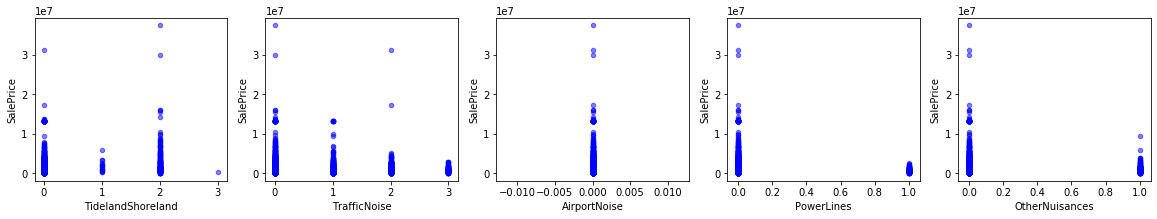

In [292]:
#Decided to drop AirportNoise, no correlation on heat map
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

for xcol, ax in zip((column5), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

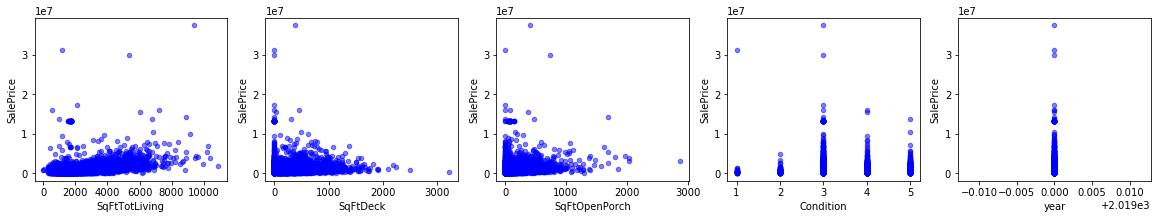

In [293]:
#year is not cosidered categorical variable
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

for xcol, ax in zip((column6), axes):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.5, color='b')

In [294]:
df

,DocumentDate,SalePrice,PropertyType,PrincipalUse,SaleReason,PropertyClass,SaleWarning,Area,SqFtLot,LakeWashington,...,TidelandShoreland,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,Condition,year
95779180,1546300800000,644950,2,6,1,8,4,27.0,6501.0,0.0,...,0.0,0.0,0.0,0,0,3265.0,0.0,30.0,3.0,2019
857600280,1546300800000,449950,2,6,1,8,,57.0,3599.0,0.0,...,0.0,0.0,0.0,0,0,2360.0,0.0,180.0,3.0,2019
769100220,1546300800000,544950,3,6,1,8,,41.0,10051.0,0.0,...,0.0,0.0,0.0,0,0,3050.0,0.0,320.0,3.0,2019
531510630,1546300800000,477000,3,6,18,8,18 51 52,34.0,9082.0,0.0,...,0.0,0.0,0.0,0,0,1620.0,0.0,0.0,4.0,2019
857600260,1546300800000,583950,2,6,1,8,,57.0,5944.0,0.0,...,0.0,0.0,0.0,0,0,3270.0,0.0,250.0,3.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951405600,1577750400000,921000,11,6,1,8,,35.0,4197.0,0.0,...,0.0,0.0,0.0,0,0,2280.0,0.0,110.0,3.0,2019
815577110,1577750400000,183000,3,6,18,8,51,61.0,6447.0,0.0,...,0.0,0.0,0.0,0,0,1790.0,80.0,0.0,3.0,2019
809001865,1577750400000,890000,3,6,8,8,12 24,12.0,4000.0,0.0,...,0.0,0.0,0.0,0,0,1820.0,0.0,70.0,3.0,2019
7942601685,1577750400000,850000,11,6,1,8,,15.0,5120.0,0.0,...,0.0,0.0,0.0,0,0,1990.0,0.0,80.0,3.0,2019


In [327]:
#After running scatter plots, we can identify our categorical variables:

#PropertyType, LakeWashington, LakeSammamish,
#SmallLakeRiverCreek, OtherView, WfntLocation, WfntBank, WfntPoorQuality, WfntRestrictedAccess,
#TidelandShoreland, TrafficNoise, PowerLines, OtherNuisances, Condition

In [296]:
df.dropna(inplace=True)

In [297]:
housing_cat_var = ['PropertyType', 'LakeWashington', 'LakeSammamish',
'SmallLakeRiverCreek', 'OtherView', 'WfntLocation', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
'TidelandShoreland', 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Condition']
housing_series = pd.Series(housing_cat_var)

cat_housing = housing_series.astype('category')
cat_housing

0             PropertyType
1           LakeWashington
2            LakeSammamish
3      SmallLakeRiverCreek
4                OtherView
5             WfntLocation
6                 WfntBank
7          WfntPoorQuality
8     WfntRestrictedAccess
9        TidelandShoreland
10            TrafficNoise
11              PowerLines
12          OtherNuisances
13               Condition
dtype: category
Categories (14, object): [Condition, LakeSammamish, LakeWashington, OtherNuisances, ..., WfntBank, WfntLocation, WfntPoorQuality, WfntRestrictedAccess]

In [328]:
#.cat.codes gives us a way to perform label encoding in a way that numerical labels are 
#always between 0 and (number_of_categories)-1

cat_housing.cat.codes

0      6
1      2
2      1
3      7
4      4
5     11
6     10
7     12
8     13
9      8
10     9
11     5
12     3
13     0
dtype: int8

In [299]:
from sklearn.preprocessing import LabelEncoder
lb_make=LabelEncoder()

housing_encoded = lb_make.fit_transform(cat_origin)

In [300]:
housing_encoded

#.cat.codes can only be used on variables that are transformed using .astype(category),
#this is not a requirement to use LabelEncoder

array([ 6,  2,  1,  7,  4, 11, 10, 12, 13,  8,  9,  5,  3,  0])

In [301]:
pd.get_dummies(cat_housing)

,Condition,LakeSammamish,LakeWashington,OtherNuisances,OtherView,PowerLines,PropertyType,SmallLakeRiverCreek,TidelandShoreland,TrafficNoise,WfntBank,WfntLocation,WfntPoorQuality,WfntRestrictedAccess
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [302]:
pd.get_dummies(cat_housing, drop_first=True)

#we dropped the Condition column to avoid the dummy variable trap
#this Condition column will now be known as our reference category

,LakeSammamish,LakeWashington,OtherNuisances,OtherView,PowerLines,PropertyType,SmallLakeRiverCreek,TidelandShoreland,TrafficNoise,WfntBank,WfntLocation,WfntPoorQuality,WfntRestrictedAccess
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,1,0,0,0,0,0


In [303]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
housing_dummies = lb.fit_transform(cat_housing)
#we will need to convert this back to a dataframe
housing_dum_df = pd.DataFrame(housing_dummies, columns=lb.classes_)
housing_dum_df

,Condition,LakeSammamish,LakeWashington,OtherNuisances,OtherView,PowerLines,PropertyType,SmallLakeRiverCreek,TidelandShoreland,TrafficNoise,WfntBank,WfntLocation,WfntPoorQuality,WfntRestrictedAccess
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [304]:
#we now want to change our categorical variable columns in the original DataFrame to our
#new dummies, while also dropping the first variable

cdtn_dummies = pd.get_dummies(df['Condition'], prefix='cdtn', drop_first=True)
lakesam_dummies = pd.get_dummies(df['LakeSammamish'], prefix='laksam', drop_first=True)
lakewas_dummies = pd.get_dummies(df['LakeWashington'], prefix='lakewas', drop_first=True)
othrnui_dummies = pd.get_dummies(df['OtherNuisances'], prefix='othrnui', drop_first=True)
othrview_dummies = pd.get_dummies(df['OtherView'], prefix='othrview', drop_first=True)
pwrlns_dummies = pd.get_dummies(df['PowerLines'], prefix='pwrlns', drop_first=True)
prptytyp_dummies = pd.get_dummies(df['PropertyType'], prefix='prptytyp', drop_first=True)
lakrivcrk_dummies = pd.get_dummies(df['SmallLakeRiverCreek'], prefix='lakrivcrk', drop_first=True)
tideshore_dummies = pd.get_dummies(df['TidelandShoreland'], prefix='tideshore', drop_first=True)
trffc_dummies = pd.get_dummies(df['TrafficNoise'], prefix='trffc', drop_first=True)
wtrbank_dummies = pd.get_dummies(df['WfntBank'], prefix='wtrbank', drop_first=True)
wtrloc_dummies = pd.get_dummies(df['WfntLocation'], prefix='wtrloc', drop_first=True)
wtrpoorq_dummies = pd.get_dummies(df['WfntPoorQuality'], prefix='wtrpoorq', drop_first=True)
wtrresacc_dummies = pd.get_dummies(df['WfntRestrictedAccess'], prefix='wtrresacc', drop_first=True)


In [306]:
#Drop the original columns, add our dummy columns

df = df.drop(['PropertyType', 'LakeWashington', 'LakeSammamish',
'SmallLakeRiverCreek', 'OtherView', 'WfntLocation', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
'TidelandShoreland', 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Condition'], axis=1)

df = pd.concat([df, cdtn_dummies, lakesam_dummies, lakewas_dummies, othrnui_dummies, othrview_dummies,
                pwrlns_dummies, prptytyp_dummies, lakrivcrk_dummies, tideshore_dummies,
                trffc_dummies, wtrbank_dummies, wtrloc_dummies, wtrpoorq_dummies, wtrresacc_dummies],
                axis=1)

In [309]:
df.shape

(25679, 60)

In [ ]:
df.drop(columns='PrincipalUse', inplace=True)

In [315]:
df.drop(columns='SaleWarning', inplace=True)

In [317]:
df.drop(columns='SaleReason', inplace=True)

In [319]:
df.drop(columns='AirportNoise', inplace=True)

In [321]:
df.drop(columns='WfntAccessRights', inplace=True)

In [323]:
df.drop(columns='WfntProximityInfluence', inplace=True)

In [326]:
#DataFrame now contains dummy data

df.columns

Index(['DocumentDate', 'SalePrice', 'PropertyClass', 'Area', 'SqFtLot',
       'WfntFootage', 'SqFtTotLiving', 'SqFtDeck', 'SqFtOpenPorch', 'year',
       'cdtn_2.0', 'cdtn_3.0', 'cdtn_4.0', 'cdtn_5.0', 'laksam_1.0',
       'laksam_2.0', 'laksam_3.0', 'laksam_4.0', 'lakewas_1.0', 'lakewas_2.0',
       'lakewas_3.0', 'lakewas_4.0', 'othrnui_1', 'othrview_2.0',
       'othrview_3.0', 'othrview_4.0', 'pwrlns_1', 'prptytyp_3', 'prptytyp_11',
       'lakrivcrk_2.0', 'lakrivcrk_3.0', 'lakrivcrk_4.0', 'tideshore_1.0',
       'tideshore_2.0', 'tideshore_3.0', 'trffc_1.0', 'trffc_2.0', 'trffc_3.0',
       'wtrbank_1.0', 'wtrbank_2.0', 'wtrbank_3.0', 'wtrbank_4.0',
       'wtrloc_1.0', 'wtrloc_3.0', 'wtrloc_4.0', 'wtrloc_5.0', 'wtrloc_6.0',
       'wtrloc_7.0', 'wtrloc_8.0', 'wtrloc_9.0', 'wtrpoorq_1.0',
       'wtrresacc_1.0', 'wtrresacc_2.0', 'wtrresacc_3.0'],
      dtype='object')

In [329]:
df

,DocumentDate,SalePrice,PropertyClass,Area,SqFtLot,WfntFootage,SqFtTotLiving,SqFtDeck,SqFtOpenPorch,year,...,wtrloc_4.0,wtrloc_5.0,wtrloc_6.0,wtrloc_7.0,wtrloc_8.0,wtrloc_9.0,wtrpoorq_1.0,wtrresacc_1.0,wtrresacc_2.0,wtrresacc_3.0
95779180,1546300800000,644950,8,27.0,6501.0,0.0,3265.0,0.0,30.0,2019,...,0,0,0,0,0,0,0,0,0,0
857600280,1546300800000,449950,8,57.0,3599.0,0.0,2360.0,0.0,180.0,2019,...,0,0,0,0,0,0,0,0,0,0
769100220,1546300800000,544950,8,41.0,10051.0,0.0,3050.0,0.0,320.0,2019,...,0,0,0,0,0,0,0,0,0,0
531510630,1546300800000,477000,8,34.0,9082.0,0.0,1620.0,0.0,0.0,2019,...,0,0,0,0,0,0,0,0,0,0
857600260,1546300800000,583950,8,57.0,5944.0,0.0,3270.0,0.0,250.0,2019,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951405600,1577750400000,921000,8,35.0,4197.0,0.0,2280.0,0.0,110.0,2019,...,0,0,0,0,0,0,0,0,0,0
815577110,1577750400000,183000,8,61.0,6447.0,0.0,1790.0,80.0,0.0,2019,...,0,0,0,0,0,0,0,0,0,0
809001865,1577750400000,890000,8,12.0,4000.0,0.0,1820.0,0.0,70.0,2019,...,0,0,0,0,0,0,0,0,0,0
7942601685,1577750400000,850000,8,15.0,5120.0,0.0,1990.0,0.0,80.0,2019,...,0,0,0,0,0,0,0,0,0,0
